<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


### ***Name***: [*Xiaoye Zhang*]
### ***username***: [*acse-xz4019*]
### ***CID***: [*01702739*]

# Import Libraries

In [1]:
# import libraries
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from livelossplot import PlotLosses

import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, ToTensor, transforms, Resize, Grayscale
from torch.utils.data import Dataset
import os, glob
from PIL import Image

import random

import numpy as np

from tqdm.auto import tqdm
from progressbar import ProgressBar

c:\Users\wasd1\miniconda3\envs\introduction-to-python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Utility Functions

##### Set seed

In [2]:
# set seed
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

#### Set device

In [3]:
# set device
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


#### Load Training Dataset

In [4]:
class TrainHandDataset(Dataset):
    """
    Dataset for training the hand classifier

    Parameters
    ----------
    root : str
        Path to the root directory containing the images
    transform : callable
        Transform to apply to the images
    
    Returns
    -------
    img : torch.Tensor
        Image tensor
    label : torch.Tensor
        Label tensor
    """
    def __init__(self, root, label,
                 transform=None):
        self.transform = transform
        self.root = root
        self.label = label
        self.data_paths = self._get_image_paths()

    def _get_image_paths(self, exts=(".jpeg", ".jpg", ".png")):
      data_paths = []
      for root, dirs, files in os.walk(self.root):
          for file in files:
              if file.endswith(exts):
                    full_path = os.path.join(root, file)
                    try:
                        with Image.open(full_path) as img:
                            # Check if the image has the shape 32x32
                            if img.size == (32, 32):
                                data_paths.append(full_path)
                            else:
                                print(f"Skip image with wrong size {full_path} with size {img.size}")
                    except (IOError, SyntaxError) as e:
                        # Skip if cannot open the image
                        print(f"Skip image cannot open {full_path}: {e}")
      return data_paths

    def __getitem__(self, idx):
        # Load image
        img_path = self.data_paths[idx]
        img = Image.open(img_path)

        # Apply the default transform
        transformm = Compose([
            Grayscale(num_output_channels=1),
            # Resize((32, 32)),  # Resize to 32x32
            ToTensor()
        ])
        img = transformm(img)

        # Apply other transforms
        if self.transform:
            img = self.transform(img)

        return img, torch.ones(1) * self.label

    def __len__(self):
        return len(self.data_paths)

#### Define train, validate, test loop

In [5]:
def regularizer(logits, arg):
    """
    Function for computing the gradient penalty

    Parameters
    ----------
    logits : torch.Tensor
        Output of the model
    arg : torch.Tensor
        Input to the model

    Returns
    -------
    reg : torch.Tensor
        Regularizer term
    """

    # Calculate gradients for real and fake data
    grad_logits = logits.requires_grad_()
    # Calculate the norms of the gradients
    grad_logits_norm = torch.norm(grad_logits.view(grad_logits.size(0), -1), dim=1)

    # Compute regularizer terms
    reg = torch.mean(torch.square(grad_logits_norm))

    return reg

def train(model, optimizer, criterion, data_loader):
    """
    Function for training the model

    Parameters
    ----------
    model : torch.nn.Module
        Model to train
    optimizer : torch.optim
        Optimizer to use for training
    criterion : torch.nn
        Loss function
    data_loader : torch.utils.data.DataLoader
        DataLoader for the training set

    Returns
    -------
    train_loss : float
        Training loss
    train_accuracy : float
        Training accuracy
    """
    model.train()
    train_loss, train_accuracy = 0, 0
    train_size = 0
    for X, y in data_loader:
        X = X.to(device).float()
        y = y.to(device).long()
        model = model.to(device)
        optimizer.zero_grad()
        output = model(X)
        regularizer_term = regularizer(output, X)
        loss = criterion(output, y.squeeze())
        loss += 0.1 * regularizer_term
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = y_pred = torch.argmax(output, dim=1).long()
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        train_size += X.size(0)
        optimizer.step()

    return train_loss/train_size, train_accuracy/train_size

def validate(model, criterion, data_loader):
    """
    Function for validating the model

    Parameters
    ----------
    model : torch.nn.Module
        Model to validate
    criterion : torch.nn
        Loss function
    data_loader : torch.utils.data.DataLoader
        DataLoader for the validation set

    Returns
    -------
    validation_loss : float
        Validation loss
    validation_accuracy : float
        Validation accuracy
    """
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    validate_size = 0
    for X, y in data_loader:
        with torch.no_grad():
            X = X.to(device).float()
            y = y.to(device).long()
            model = model.to(device)
            output = model(X)
            loss = criterion(output, y.squeeze())
            validation_loss += loss*X.size(0)
            y_pred = torch.argmax(output, dim=1).long()
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)
            validate_size += X.size(0)

    return validation_loss/validate_size, validation_accuracy/validate_size

def test(test_loader, model, metric, criterion):
    """
    Function for testing the model

    Parameters
    ----------
    test_loader : torch.utils.data.DataLoader
        DataLoader for the test set
    model : torch.nn.Module
        Model to test
    metric : callable
        Metric to use for testing
    criterion : torch.nn
        Loss function

    Returns
    -------
    y_preds : np.array
        Predicted labels
    ys : np.array
        True labels
    loss : float
        Test loss
    accuracy : float
        Test accuracy
    """
    model.eval()
    ys, y_preds = [], []
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device).float()
            y = y.to(device).long()
            model = model.to(device)

            # Train model on real data
            model_output = model(X)
            y_pred = torch.argmax(model_output, dim=1).long()
            loss = criterion(model_output, y.squeeze())
            accuracy = accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())

            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0), loss.item(), accuracy.item()


#### Define train, test function

In [6]:
def model_train(model, optimizer, criterion, train_loader, validation_loader=None, n_epochs=100,
                model_path="./models/Classifier_{:04d}.pth", epoch_start=0, load_model=False,
                save_model=False, save_frequency=100):
      """
      Function for training the model

      Parameters
      ----------
      model : torch.nn.Module
            Model to train
      optimizer : torch.optim
            Optimizer to use for training
      criterion : torch.nn
            Loss function
      train_loader : torch.utils.data.DataLoader
            DataLoader for the training set
      validation_loader : torch.utils.data.DataLoader
            DataLoader for the validation set
      n_epochs : int
            Number of epochs to train
      model_path : str
            Path to save the model
      epoch_start : int
            Epoch to start training from
      load_model : bool
            Whether to load the model
      save_model : bool
            Whether to save the model
      save_frequency : int
            Frequency to save the model
      """
      liveloss = PlotLosses()
      start_epoch = 1
      
      if load_model:
            model.load_state_dict(torch.load(model_path.format(epoch_start)))
            start_epoch = epoch_start + 1

      for epoch in tqdm(range(start_epoch, n_epochs+1)):
            logs = {}
            train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

            logs['' + 'Loss'] = train_loss.item()
            logs['' + 'Accuracy'] = train_accuracy.item()
            if validation_loader:
                validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
                logs['val_' + 'Loss'] = validation_loss.item()
                logs['val_' + 'Accuracy'] = validation_accuracy.item()

            liveloss.update(logs)
            liveloss.draw()
            
            if save_model:
                  # save every save_every epochs
                  if(np.mod(epoch, save_frequency) == 0):
                        torch.save(model.state_dict(), model_path.format(epoch))

def model_test(test_loader, model, metric, criterion):
      """
      Function for testing the model

      Parameters
      ----------
      test_loader : torch.utils.data.DataLoader
            DataLoader for the test set
      model : torch.nn.Module
            Model to test
      metric : callable
            Metric to use for testing
      criterion : torch.nn
            Loss function

      Returns     
      -------
      y_preds : np.array
            Predicted labels
      ys : np.array
            True labels
      """
      y_preds, y_trues, loss, accuracy = test(test_loader, model, metric, criterion)
      print(f"Test loss: {loss:.4f} | Test accuracy: {accuracy:.4f}")

      return y_preds, y_trues

### Test and predict function

In [13]:
class TestHandDataset(Dataset):
    """
    Dataset for testing the hand classifier

    Parameters
    ----------
    root : str
        Path to the root directory containing the images
    transform : callable
        Transform to apply to the images

    Returns
    -------
    img : torch.Tensor
        Image tensor
    label : torch.Tensor
        Label tensor
    """
    def __init__(self, root,
                 transform=None):
        self.transform = transform
        self.root = root
        self.data_paths = self._get_image_paths()

    def _get_image_paths(self, exts=(".jpeg", ".jpg", ".png")):
        data_paths = []
        for root, dirs, files in os.walk(self.root):
            for file in sorted(files):  # 确保文件按名称排序
                if file.endswith(exts):
                    full_path = os.path.join(root, file)
                    try:
                        with Image.open(full_path) as img:
                            data_paths.append(full_path)
                    except (IOError, SyntaxError) as e:
                        print(f"Skip image cannot open {full_path}: {e}")
        return data_paths

    def __getitem__(self, idx):
        # Load image
        img_path = self.data_paths[idx]
        img = Image.open(img_path)

        # Resize or pad-and-crop the image to 32x32
        transformm = Compose([
            Grayscale(num_output_channels=1),
            Resize((32, 32)),  # Resize to 32x32
            ToTensor()
        ])
        # Apply the transform
        img = transformm(img)

        # Apply other transforms
        if self.transform:
            img = self.transform(img)

        return img, img_path

    def __len__(self):
        return len(self.data_paths)

def predict(dataloader, model):
    """
    Function for predicting the labels

    Parameters
    ----------
    dataloader : torch.utils.data.DataLoader
        DataLoader for the test set
    model : torch.nn.Module
        Model to test

    Returns
    -------
    predictions : np.array
        Predicted labels
    """
    model.eval()
    predictions = []
    for X, _ in dataloader:
        with torch.no_grad():
            X = X.to(device).float()
            model = model.to(device)
            output = model(X)
            y_pred = torch.argmax(output, dim=1).long()
            predictions.append(y_pred.cpu().numpy())

    return predictions

# Data preparation

In [7]:
# Create the datasets
transform = transforms.Compose([transforms.RandomHorizontalFlip(p=0.4),         # Randomly flip the image with probability of 0.4
                                transforms.RandomRotation(15),])                # Randomly rotate the image with angle of 15 degrees
real_hands = TrainHandDataset(root='./real_hands/',label=0, transform=transform)
GAN_hands = TrainHandDataset(root='./GAN_hands/', label=2, transform=transform)
VAE_hands = TrainHandDataset(root='./VAE_hands/', label=1, transform=transform)

# Concatenate the datasets
combined_dataset = ConcatDataset([real_hands, GAN_hands, VAE_hands])
trainset, testset = train_test_split(combined_dataset, test_size=0.2, random_state=42)
trainset, valset = train_test_split(trainset, test_size=0.2, random_state=42)

Skip image with wrong size ./GAN_hands/GAN_hand_099.jpeg with size (32, 24)
Skip image with wrong size ./GAN_hands/GAN_hand_108.jpeg with size (32, 24)
Skip image cannot open ./GAN_hands/GAN_hand_147.jpeg: cannot identify image file './GAN_hands/GAN_hand_147.jpeg'
Skip image with wrong size ./GAN_hands/GAN_hand_171.jpeg with size (10, 32)
Skip image with wrong size ./GAN_hands/GAN_hand_217.jpeg with size (32, 24)
Skip image cannot open ./GAN_hands/GAN_hand_235.jpeg: cannot identify image file './GAN_hands/GAN_hand_235.jpeg'
Skip image with wrong size ./GAN_hands/GAN_hand_257.jpeg with size (10, 32)
Skip image cannot open ./GAN_hands/GAN_hand_273.jpeg: cannot identify image file './GAN_hands/GAN_hand_273.jpeg'
Skip image with wrong size ./GAN_hands/GAN_hand_371.jpeg with size (10, 32)
Skip image with wrong size ./GAN_hands/GAN_hand_426.jpeg with size (32, 24)
Skip image with wrong size ./GAN_hands/GAN_hand_506.jpeg with size (10, 32)
Skip image with wrong size ./VAE_hands/VAE_hand_072.j

# Network design and implementation

I choose a simple convolutional neural network as my final design (inspired from https://poloclub.github.io/cnn-explainer/). This network is designed consisting of 2 convolutional blocks, each block has two convolutional layers; between blocks there is a maxpooling layer; there are 2 fully connection layers attached behing the convolutional layers. After plenty of trying, I found a shallow networks performs better. The advantage of using a small CNN like it is that it has less parameters than other complex networks (e.g., ResNet50), make it easily trainable; simpler networks can also prevent overfitting because it is too shallow to learn too much. CNNs can abstract the features (distributions) of targets efficiently.

### Define the SimpleCNN model

In [8]:
class SimpleCNN(nn.Module):
    """
    Simple CNN model for classifying the images

    Parameters
    ----------
    None

    Returns
    -------
    None
    """
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1_1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.conv1_2 = nn.Conv2d(in_channels=self.conv1_1.out_channels, out_channels=self.conv1_1.out_channels*2, kernel_size=3, padding=1)
        
        # Second conv block
        self.conv2_1 = nn.Conv2d(in_channels=self.conv1_2.out_channels, out_channels=self.conv1_2.out_channels*2, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(in_channels=self.conv2_1.out_channels, out_channels=self.conv2_1.out_channels*2, kernel_size=3, padding=1)
        
        # Pooling layer between two blocks
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers for classification
        self.fc1 = nn.Linear(self.conv2_2.out_channels * 8 * 8, self.conv2_2.out_channels * 2)
        self.fc2 = nn.Linear(self.fc1.out_features, 3) # 3 classes

    def forward(self, x):
        # First block
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.pool(x)

        # Second block
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.pool(x)

        # Flatten the output for the fully connected layer
        x = x.view(-1, self.conv2_2.out_channels * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Define the hyperparamerters
**Almost the best parameters after fine-tuning**

**Cross-entropy loss is the most suitable and commonly used for multi-class classification problems. It considers not just the probability of correct classification but also accounts for the probability of incorrect classifications, enabling more effective learning during training**

In [9]:
model = SimpleCNN()
batch_size = 32
learning_rate = 1e-5
creterian = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training

### Train the model

In [ ]:
# Create the dataloaders
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloader = DataLoader(valset, batch_size=1000, shuffle=False, num_workers=0)
test_dataloader = DataLoader(testset, batch_size=1000, shuffle=False, num_workers=0)

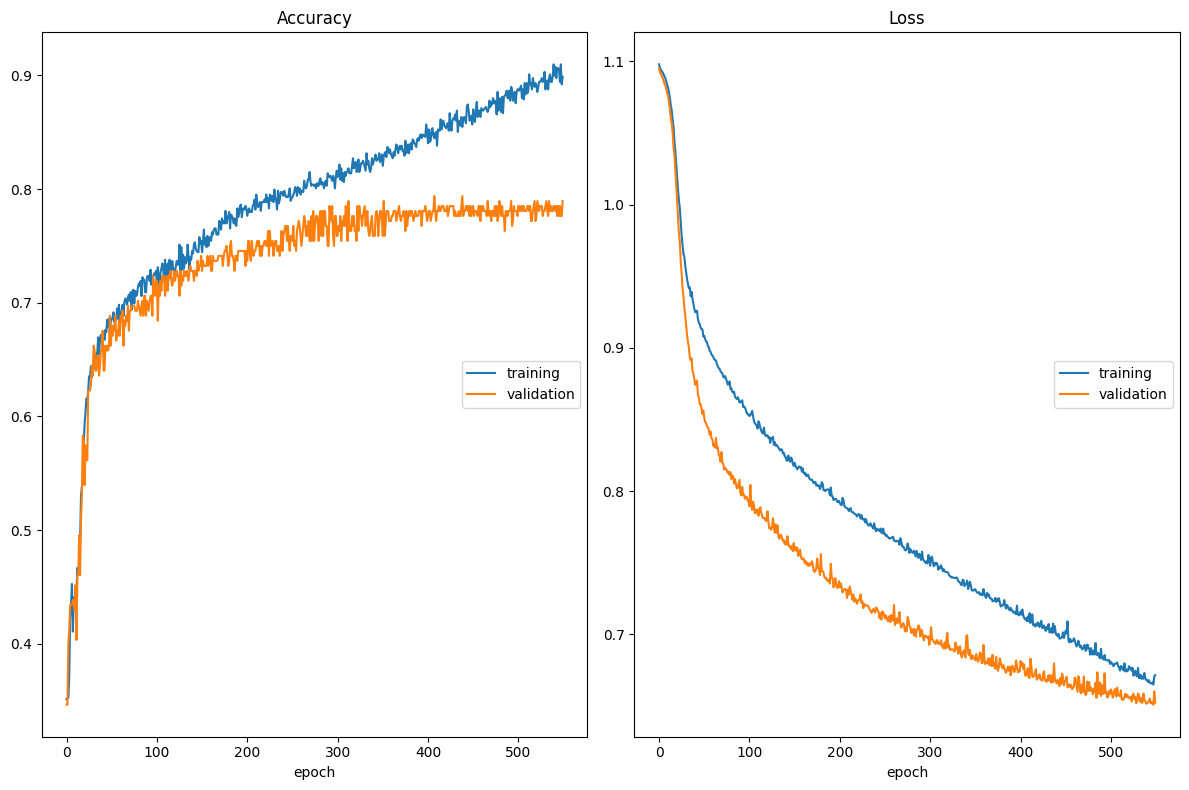

100%|██████████| 550/550 [03:42<00:00,  2.47it/s]

Accuracy
	training         	 (min:    0.351, max:    0.910, cur:    0.899)
	validation       	 (min:    0.346, max:    0.794, cur:    0.789)
Loss
	training         	 (min:    0.665, max:    1.098, cur:    0.672)
	validation       	 (min:    0.651, max:    1.095, cur:    0.652)


In [ ]:
model_train(model, optimizer, creterian, train_dataloader, val_dataloader, n_epochs=550, 
            model_path="./models/Classifier_{:04d}.pth", epoch_start=0, load_model=False, save_model=False, save_frequency=50)

### Evaluate the model

Test loss: 0.6244 | Test accuracy: 0.8140


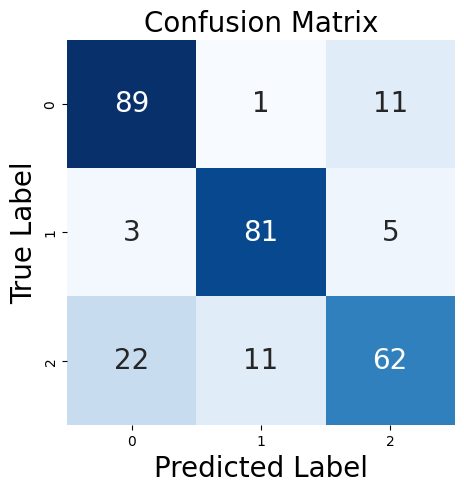

In [ ]:
from usages import model_test
y_preds, y_trues = model_test(test_loader=test_dataloader, model=model, metric=accuracy_score, criterion=nn.CrossEntropyLoss())
cm = confusion_matrix(y_true=y_trues, y_pred=y_preds)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cbar=False, cmap=plt.cm.Blues, annot_kws={"size": 20})
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel('True Label', fontsize=20)
plt.xlabel('Predicted Label', fontsize=20)
plt.show()

**Overall good score, but can be improved. The low score mainly because the size of training data is too small.**

### Use all the data train the model

In [10]:
# Create the dataloaders using the whole datasets
train_dataloader = DataLoader(combined_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

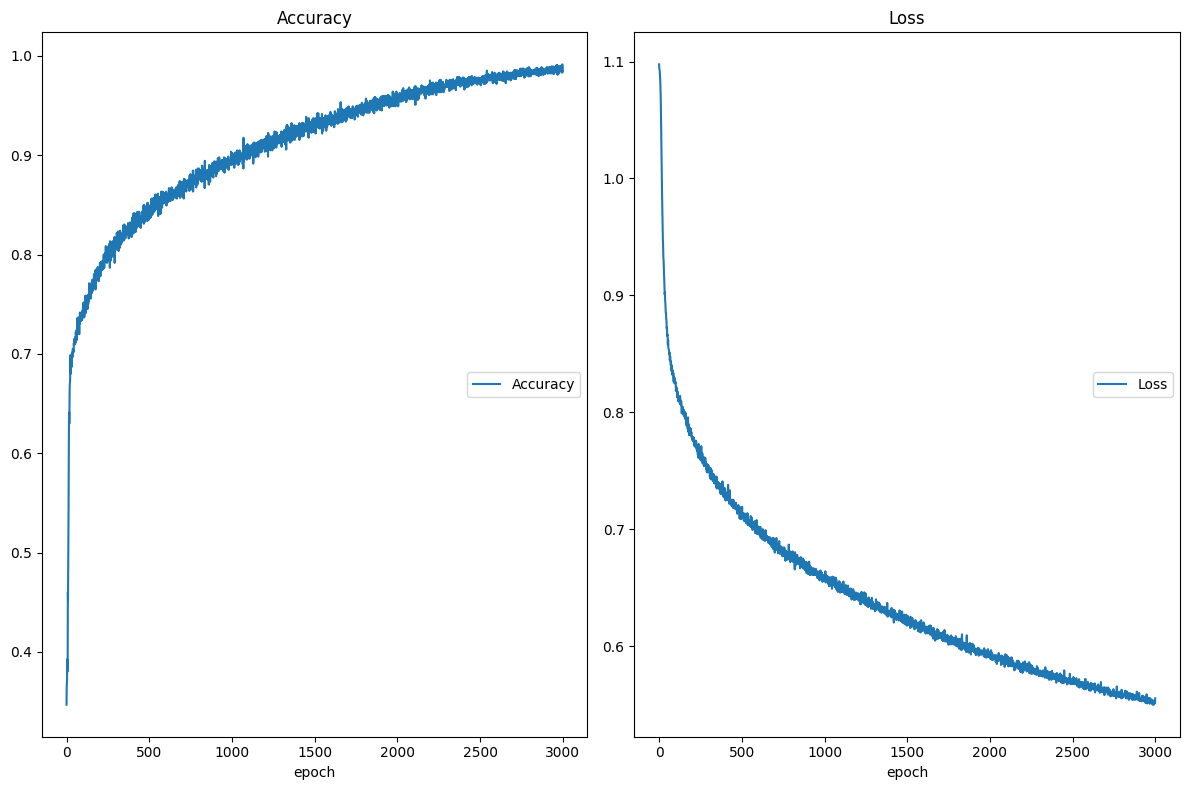

100%|██████████| 3000/3000 [1:15:35<00:00,  1.51s/it]

Accuracy
	Accuracy         	 (min:    0.347, max:    0.992, cur:    0.985)
Loss
	Loss             	 (min:    0.550, max:    1.098, cur:    0.556)


In [11]:
# Train the model
model_train = model_train(model, optimizer, creterian, train_dataloader, n_epochs=3000, model_path="./models/Classifier_{:04d}.pth", epoch_start=0, load_model=False, save_model=True, save_frequency=50)   

It is clear that the loss continuouly decreases, the training are consistently happening and gradient disappear does not happen. Because I add regularisation term to the loss function, the overfitting should be suppressed.

#### If need, load the best model

In [ ]:
# Load the model
model.load_state_dict(torch.load("./models/Classifier_3000.pth"))

# Use the trained model to predict the test_hands dataset

In [14]:
# Create the test dataloader
dataset = TestHandDataset(root='test_hands')
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10000, shuffle=False)

# Predict the labels
predictions = predict(dataloader, model) # a list contains an array of predictions

Skip image cannot open test_hands\test_hand_3551.jpeg: cannot identify image file 'test_hands\\test_hand_3551.jpeg'


### Output the predictions and write into a .csv file

In [15]:
import csv
import glob
import os  # For extracting filename from path

# a list
my_array_list = predictions[0].tolist()

# Path to the folder containing images
image_folder_path = './test_hands/'

# List all image files matching the pattern
image_files = glob.glob(f"{image_folder_path}/test_hand_????.*")

# Ensure the lists are of the same length
max_length = max(len(my_array_list), len(image_files))
my_array_list.extend([''] * (max_length - len(my_array_list)))
image_files.extend([''] * (max_length - len(image_files)))

# Open a file in write mode
with open('acse-xz4019_classified_hands.csv', 'w', newline='') as file:
    writer = csv.writer(file)

    # Initialize a variable to track if the special case has been handled
    special_case_handled = False

    # Write data
    for i, image_file in enumerate(image_files):
        # Extract filename
        filename = os.path.basename(image_file)

        # Check if the filename is the one to fill with 0
        # (the one that is missing from the predictions, see the output of the cell above)
        if filename == 'test_hand_3551.jpeg':
            # Write 0 for this file and flag that the special case has been handled
            writer.writerow([filename, 0]) # you need to manually delete this row from the csv file
            special_case_handled = True
        elif filename.startswith('test_hand_'):
            # Adjust the index if the special case has been handled
            array_index = i - 1 if special_case_handled else i
            # Write the filename and adjusted array item
            writer.writerow([filename, my_array_list[array_index] if array_index < len(my_array_list) else ''])